<h1><center> Final Project
<center>---
<center>Community finding algorithm

<h3><center> CS166 Prof. Scheffler, Prof. Ribeiro <h4><center>Michelle Hackl
---

## Model Description

Devising extension to the network simulation model of the previous assignment, I was interested in visualizing networks in more intuitive ways that allow the viewer to derive information from them quickly and efficiently. In particular, I was intrigued by the multi-cluster building that might occur when multiple opinions are introduced into the simulation. The question of how well-connected clusters stay interested me, more than the final communities that build once the network separates. This information seemed not easily accessible to me by the clustered spring-layout visualizations. To utilize the more accessible shell-layout, however, communities needed to be assigned first.


### Existing Models

Networkx currently supports several different community-finding algorithms, most of which, however, fail to take edge-weights into account. The only algorithm that does this is asyn_lpa_communities(). It takes edge-weight into account, generating small clusters based on asynchronous label propagation. To visualize the opinion-clusters, however, I found it inadequate, since it returns tiny clusters on most graphs that aren't highly connected (i.e., performs well on Barabasi-Albert graphs with m>4, which my algorithm does poorly on). Trying to model real-world social situations, however, such densely connected graphs are unlikely to occur. While I originally planned on testing my algorithm against the Asynchronous Label Propagation method, the vastly different types of clusters they produced led me to abandon this idea.


### My Model

The below community-finding algorithm is based on the idea that nodes in the network could behave like bodies in a physics simulation, attracting and repelling each other based on an attraction component between them. In particular, the algorithm determines a random starting location for each node and then synchronously updates each 2D location based on proximity and attraction (determined by edge weight) to each of its neighbors. In theory, this would lead to nodes belonging to distinct communities to converge to differing locations on the grid, attracting each other more strongly if their edge-weight is high. Once converged, the communities could be retrieved by feeding the final positions into a k-means clustering algorithm (here, in particular, DBSCAN, as it does not require the user to specify k).


### Modeling Assumptions

The simulation approach above assumes that nodes of differing communities will converge to distinct points in the grid. While communities are likely to converge, there is no particular part of the algorithm that guarantees that two communities cannot converge to the same (or closeby) points on the grid. This issue is in part avoided by randomly assigning starting locations, in part by performing the clustering repetitively. The algorithm performs multiple such simulations, keeping track of each node's label and finally returning clusters based on the best cluster assignment (this is achieved with a particular sort of the assignments at each step before assigning labels). The impact of random initial positions is evaluated using a self-derived metric of internal consistency, details below.

### Parameters and Update equations

The community-finding algorithm uses the following update equation to determine a node's new location (x, y) on the 2-d grid:

$ x_{new} = x_{old} + \Delta x $

$ y_{new} = y_{old} + \Delta y $

where

$\Delta x = \sum_{j=1}^{n} \phi * (x_j - x_i) * w_{ij}$

$\Delta y = \sum_{j=1}^{n} \phi * (y_j - y_i) * w_{ij}$

$n$ denotes the neighbors the node is connected to and $w_{ij}$ the weight of the edge between the two nodes. Here, $\phi$ determines the speed of updating, as a percentage of the distance that two nodes traverse toward one another when their node weight is equal to 1. High $\phi$ values lead to rapid convergence, but the single-cluster building is more likely to occur since nodes with high edge-weights attract the ones around them rapidly. 

### Measuring outcomes

The algorithm is evaluated by determining how self-consistent it performs in assigning nodes to communities. Assuming that if it tends to assign the same community-labels to nodes regardless of the initial starting positions, this means that the simulation "converged" on an answer easily.
I have defined self-consistency (here SC) as a percentage score for each individual node (with the algorithm-score simply being the mean over all nodes' scores). 

$ SC = \frac{times\ assigned\ final\ label}{total\ number\ of\ runs}$

This metric allows me to determine how often the simulation has to be run until it manages to generate consistent community assignments.

## Code

In [146]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

from scipy import stats
import networkx as nx
import random as rd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

rd.seed(1)

### Original Network Simulation Class

In [182]:
class SocialDynamicsSimulation(object):
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4,
                 network_type="barabasi"):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
            small-world network. Default: 50.

            alpha (float) speed of opinion change with which the nodes will
            change their opinions to fit or move away from their neighbors.
            With modification 1, this is replaced by tau.
            Default: 0.03. Range: (0,0.5]

            beta (float) scales the amount by which weights change, meaning how
            quickly differing opinions can affect the strength of an existing
            relationship between two nodes. Default: 0.3. Range: (0,1)

            gamma (float) determines how much a difference in opinions affects
            weight change. Default: 4.
            
            network_type (string) Sets the network type to one of the most common
            graph types (Barabasi-Albert, Watts-Strogatz or Erdos-Renyi).
            Individual graph parameters are currently unsupported.
            Default: "barabasi". Options: ["barabasi", "watts", "erdos"]
        '''
        
        self.network_size = network_size
        self.finished = False
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        network_options = ["barabasi", "watts", "erdos"]
        if network_type not in network_options:
            print("That's not a valid graph type, using Barabasi-Albert graph instead.")
            self.network_type = "barabasi"
        else:
            self.network_type = network_type
            

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        Initiates the age of a connection to 1.
        '''
        if self.network_type == "erdos":
            self.graph = nx.erdos_renyi_graph(self.network_size, 0.15)
        elif self.network_type == "watts":
            self.graph = nx.watts_strogatz_graph(self.network_size, 4, 0.1)
        else:
            self.graph = nx.barabasi_albert_graph(self.network_size, 3)
        
        self.cross_cluster_connections = len(self.graph.edges)

        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = rd.randint(0, 1)
            
        self.layout = nx.spring_layout(self.graph)
        self.step = 0
        

    def get_layout(self, graph_type = "shell"):
        '''
        Retrieves parameters for plotting.
        Graph types:
        
            "spring" (str) default graph layout with nodes arranged randomly.
            
            "shell" (str) two-layer shell layout with nodes arranged by 
            their opinion (above or below 0.5). Displays only connections
            that exist between nodes with opinions that differ by at least
            0.1.
        '''
        self.plotting = self.graph.copy()
        
        if graph_type == "shell":
            
            inner_shell = []
            outer_shell = []

            for node in self.graph.nodes:
                if self.graph.node[node]['opinion'] > 0.5:
                    inner_shell.append(node)
                else: outer_shell.append(node)

            shell_pos = [inner_shell, outer_shell]
            
            print(shell_pos)
            

            edges_to_remove = []
            for edge in self.plotting.edges:
                n_1 = self.plotting.nodes[edge[0]]['opinion']
                n_2 = self.plotting.nodes[edge[1]]['opinion']
                                
                if abs(n_1 - n_2) < 0.1:
                    edges_to_remove.append(edge)

            if edges_to_remove:
                for edge in edges_to_remove:
                    self.plotting.remove_edge(*edge)
        
            self.layout = nx.shell_layout(self.plotting, nlist=shell_pos)
        
        if graph_type == "spring":
            self.layout = nx.spring_layout(self.plotting, pos=self.layout, iterations=5)
        

    def update(self, end_if_broken = True):
        """
        Updates the simulation by a single time step.
        
        Inputs:
            end_if_broken (bool) if True, the simulation will end
            once there are no more connections between nodes of 
            differing opionions (as determined by the check_clustering
            algorithm). Default: True.
        """
        self.form_connection()
               
        if not self.finished:
            self.check_clustering()
        elif end_if_broken:
            return
        
        if rd.uniform(0, 1) < 0.99:
            edge = rd.choice(list(self.graph.edges))             #pick a random node
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]

            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (         #update opinion
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))


            self.graph.edges[edge]['weight'] = (                 #update weights
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))

            if self.graph.edges[edge]['weight'] < 0.05:          #remove connection if too weak
                self.graph.remove_edge(*edge)
        
        self.step += 1

    
    def check_clustering(self):
        """
        Checks if the graph is fully clustered (disconnected).
        If so, it ends the simulation.
        """
        self.clustering = self.graph.copy()
        
        edges_to_remove = []
        for edge in self.clustering.edges:
            n_1 = self.clustering.nodes[edge[0]]['opinion']
            n_2 = self.clustering.nodes[edge[1]]['opinion']

            if abs(n_1 - n_2) < 0.1:
                edges_to_remove.append(edge)

        if edges_to_remove:
            for edge in edges_to_remove:
                self.clustering.remove_edge(*edge)
        
        if not self.clustering.edges:
            self.finished = True
#             print("Disconnected the graph at %d steps." %self.step)

         
    
    def form_connection(self):
        """
        Creates a random new connection with a chance of 1% between
        two previously unconnected nodes.
        """
        if rd.uniform(0, 1) < 0.01:
            nodes = list(self.graph.nodes)
            while True:                              
                new_edge = rd.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break

            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5, age=1)
        
        
    def run(self, runs = 9, step_size = 2000, visualize = True,
            graph_type = "shell"):
        """
        Runs the simulation and visulizes the results in a grid.
        For simplicity in plotting, number of runs are adjusted
        to fit with the grid.
        
        Plotting parameters are retrieved from get_layout(), this is
        particularly imporant for shell-type plots.
        
        Inputs:
            runs (int) How many distinct plots should be generated
            differing each by step_size updates. Default: 9
            
            step_size (int) How many update steps to perform for 
            each visualization. Default: 2000
            
            visualize (bool) If the plots should be printed.
            Default: True
            
            graph_type (str) The type of graph to display the updates
            in. Options: ['shell', 'spring']. Default: 'shell'
        """
        if visualize:
            plt.clf()
            
            while runs % 3 != 0:
                runs += 1
            
            n = 3
            m = np.ceil(runs/n)
            
            plot_ind = 1
            
            f, axes = plt.subplots(int(m), n , figsize=(n*4, m*4), sharex=True, sharey=True)
            
            self.get_layout(graph_type)                         #plot initial Setup
                
            plt.subplot(int(m), n , plot_ind)    
            nx.draw(
                self.plotting, pos=self.layout, with_labels=True,
                node_color=[self.plotting.nodes[i]['opinion'] for i in self.plotting.nodes],
                edge_color=[self.plotting.edges[i, j]['weight'] for i, j in self.plotting.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                cmap=plt.cm.coolwarm, node_vmin=0, node_vmax=1,
                alpha=0.7, vmin=0, vmax=1)

            plt.title('Initial at step: ' + str(self.step))
            plot_ind += 1
                
                
            for r in range(runs-1): 
                for step in range(step_size):                      #update simulation and then plot
                    self.update(end_if_broken = False)
                    
                self.get_layout(graph_type)

                plt.subplot(int(m), n , plot_ind)    
                nx.draw(
                    self.plotting, pos=self.layout, with_labels=True,
                    node_color=[self.plotting.nodes[i]['opinion'] for i in self.plotting.nodes],
                    edge_color=[self.plotting.edges[i, j]['weight'] for i, j in self.plotting.edges],
                    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                    cmap=plt.cm.coolwarm, node_vmin=0, node_vmax=1,
                    alpha=0.7, vmin=0, vmax=1)

                plt.title('Step: ' + str(self.step))
                plot_ind += 1

            f.tight_layout()
            plt.show()
        else:
            for r in range(runs-1):
                for step in range(step_size):
                    self.update()


### Community Finding Algorithm

In [183]:
from sklearn.cluster import DBSCAN
from networkx.algorithms.community.asyn_lpa import asyn_lpa_communities

In [184]:
class CommunityAlgorithm(SocialDynamicsSimulation):
    """
    Implements the community finding algorithm. This class
    inherits the properties and methods from the
    SocialDynamicsSimulation parent class.
    """
    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4,
                 network_type="barabasi"):
        """
        Inputs:
            Same as parent class.
        """
        SocialDynamicsSimulation.__init__(self, network_size, alpha, beta,
                                          gamma, network_type)
        

        
    def community_finding(self, phi=0.2, com_steps=50, clustering_trials=3,
                          visualize=True):
        """
        This is the main algorithm function that calls on all other
        functions that are needed to perform the clustering.
        
        Inputs:
            phi (float) The speed at which the node locations are 
            updated. High phis lead to extreme clustering too 
            quickly. Default: 0.2.
            
            com_steps (int) Determines how many times the node-locations
            are updated before clustering is performed on them.
            Testing for convergence is currently not supported.
            Default: 50.
            
            clustering_trials (int) How many different random initial
            layouts are tested for the same network to deter-
            mine the communities. Default: 3
            
            visualize (bool) Whether or not to plot the final
            communities in the shell layout. Default: True
        """
        
        self.phi = phi                                #initializing parameters
        self.com_steps = com_steps
        
        self.locations = nx.spring_layout(self.graph, iterations=0)
        
        for node in self.graph.nodes:                 #initializing a list of labels
            self.graph.nodes[node]['labels'] = []
        
        for t in range(clustering_trials):
            
            self.update_pos()
#             self.test_for_convergence()             #not implemented, but would be ideal
            self.cluster()
            
        self.retrieve_clusters()
        if visualize:
            self.visualize_clusters()
        
        self.generate_cluster_stats()
        return(self.total_SC_scores)


#---------------------------------
# POSITIONING FUNCTIONS
#---------------------------------

    def update_pos(self):
        """
        Performs synchronous updates on node positions
        for each node in the system.
        """
        self.locations = {}                         #randomly generates original positions
        for n in range(0, self.network_size):
            self.locations[n] = np.random.uniform(0, 1, 2)
        
        for s in range(self.com_steps):             #updates happen com_step times
            nodes = list(self.graph.nodes)
        
            for update_node in nodes:
                friends = list(self.graph.neighbors(update_node))

                if friends:
                    new_loc = self.get_new_location(update_node, friends)
                    self.locations[update_node] = new_loc
                    
                    
            
    def get_new_location(self, node, friends):
        """
        Gets the new x,y position for the chosen node
        based on its neighboring nodes.
        
        Updates x,y positions based on the following
        update equation(s): delta_x = phi * (x_i - x_j) * w_ij
        
        Inputs:
            node (int) The node for which location updates
            are to be performed.
            
            friends (list) List of all nodes connected to
            the update node.  
        """ 
        cur_loc = np.array(self.locations.get(node))

        for f in friends:
            friend_loc = np.array(self.locations.get(f))
            edge_weight = self.graph.edges[(node, f)]['weight']

            for i in [0, 1]:                    #update in x and y direction
                delta = self.phi * (friend_loc[i] - cur_loc[i]) * edge_weight
                cur_loc[i] += delta 
                
        return(cur_loc)

    
#---------------------------------
# CLUSTERING FUNCTIONS
#---------------------------------
 
    def cluster(self):
        """
        Takes as input the final node positions that the update_pos()
        function converges on and performs clustering on them. 
        Cluster assigments are stored in a node attribute to later
        retrieve most frequent label assignment.
        
        The eps parameter to the DBSCAN function is scaled by the 
        current dimensions of the node positions on the grid (depends 
        on number of update steps that are performed).
        
        Note on list of lists:
            I use this format (instead of using the labels directly) to
            account for shifting clusters.
            i.e. if node 0 is sometimes assigned to a cluster, sometimes alone,
            this will shift all other labels by 1, but they might otherwise
            be in the exact same clusters every time. With the list sort, I
            move small clusters to the end, making cluster labels derived from 
            sublist indexes more consistent (aka. only the 0 node would have
            varying labels if it gets sometimes clustered, sometimes not)
            and variance more representative of the actual performance
            of the algorithm.
            
            Edge case: If two large clusters tend to be about the same
            length, the lables might vary back and forth between the
            two indexes.
        """
        #location data for clustering algorithm
        loc_data = np.zeros((self.network_size, 2))
        for key, value in self.locations.iteritems():
            loc_data[key,:] = value
        
        #clustering
        eps_scaler = (max([v[0] for k, v in self.locations.iteritems()]) -
                      min([v[0] for k, v in self.locations.iteritems()]))
        
        eps = 0.1*eps_scaler
        
        clustering = DBSCAN(eps = eps, min_samples = 1).fit(loc_data)
        
        #converting the clusters to a list of lists (so it can be sorted later)
        clusters = [[] for _ in range(max(clustering.labels_)+1)]
        
        for node_num, cluster in enumerate(clustering.labels_):
            clusters[cluster].append(node_num)
        
        #sorting the clusters
        clusters.sort(reverse=False, key= lambda x : len(x) if len(x) > 2 else self.network_size)
        
        #appending each node's label to a list of labels
        #as a node attribute
        for label, cluster in enumerate(clusters):
            for node in cluster:
                self.graph.nodes[node]['labels'].append(label)
        
        self.clusters = clusters

    
    def retrieve_clusters(self):
        """
        From all the labels that nodes have received in the simulation
        this functions gets the mode label and assigns it to the 
        cluster attribute.
        """
        num_of_communities = 0
        
        #assigns the mode of each label_list as the community of a node
        for node, label_list in self.graph.nodes.data('labels'):
            community = stats.mode(label_list)[0]
            num_of_communities = max(num_of_communities, community)

            self.graph.nodes[node]['community'] = community
        
        #retrieves the clusters (for plotting) from the modes
        clusters = [[] for _ in range(num_of_communities+1)]
        
        for node, community in self.graph.nodes.data('community'):
            clusters[community[0]].append(node)
        
        clusters.sort(reverse=False, key= lambda x : len(x) if len(x) > 2 else self.network_size)
        
        self.clusters = clusters

        
#---------------------------------
# STATISTICS FUNCTIONS
#---------------------------------

    def generate_cluster_stats(self):
        """
        Calculates self-consistency (SC) of the cluster-assignments
        of every node.
        SC is the fraction of times the node was assigned to the 
        final cluster out of every cluster run. The list of each
        node's SC score is retained for generating confidence
        intervals/mean on SC scores.
        """
        total_SC_scores = []
           
        #assigns the mode of each label_list as the community of a node
        for node, label_list in self.graph.nodes.data('labels'):
            
            mode = self.graph.nodes[node]['community']
            times_assigned_mode = len([x for x in label_list if x==mode])
            SC = float(times_assigned_mode) / len(label_list)
            
            self.graph.nodes[node]['SC'] = SC
            total_SC_scores.append(SC)
        
        self.total_SC_scores = total_SC_scores

           
#---------------------------------
# PLOTTING FUNCTIONS
#---------------------------------

    def visualize_clusters(self):
        """
        Visualizes the final communities. Removes edges from the graph that
        are within-cluster and only displays connections between clusters.
        """
        self.plotting = self.graph.copy()
        self.layout = nx.shell_layout(self.plotting, nlist=self.clusters)

        
        edges_to_remove = []
        
        for cluster in self.clusters:
            for i in range(len(cluster)):
                for j in range(i, len(cluster)):
                    edge_test = (cluster[i], cluster[j])
                    if edge_test in self.plotting.edges:
                        edges_to_remove.append(edge_test)

        if edges_to_remove:
            for edge in edges_to_remove:
                self.plotting.remove_edge(*edge)
                
        if not self.plotting.edges:
            print("Communities are not connected.")
        
        plt.clf()
        nx.draw(
            self.plotting, pos=self.layout, with_labels=True,
            node_color=[self.plotting.nodes[i]['opinion'] for i in self.plotting.nodes],
            edge_color=[self.plotting.edges[i, j]['weight'] for i, j in self.plotting.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            cmap=plt.cm.coolwarm, node_vmin=0, node_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Communities identified')
        plt.show()
        
        

#---------------------------------
# DISCARDED FUNCTIONS
#---------------------------------
    
#     def test_visual(self):
#         """
#         Test visualization for debugging.
#         """
#         self.plotting = self.graph.copy()
        
#         plt.clf()
#         nx.draw(
#             self.plotting, pos=self.locations, with_labels=True,
#             node_color=[self.plotting.nodes[i]['opinion'] for i in self.plotting.nodes],
#             edge_color=[self.plotting.edges[i, j]['weight'] for i, j in self.plotting.edges],
#             edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
#             cmap=plt.cm.coolwarm, node_vmin=0, node_vmax=1,
#             alpha=0.7, vmin=0, vmax=1)
#         plt.title('Testing for bugs and strange behavior')
#         plt.show()
        
#     def test_for_convergence(self):
#         """
#         Not implemented, but would be ideal to have.
#         """
#         convergence = True
#         #test if the x/y movements have slowed down/stopped
#         #would ideally track delta history and calculate
#         #variance accross them
#         #if not converged, would continue updating positions
        
#         if not convergence:
#             self.update_pos()
#         else:
#             pass
                
#     def renormalize(self):
#         """
#         Not needed. Scaled eps parameter instead.
# 
#         Rescales the network so nodes are on the grid from 0 to 1.
#         This is done so the clustering algorithm's e(distance) 
#         parameter can be set to a consistant number.
#         """   
# #         print("Original location: ", self.locations)
#         x_renorm_fact = 1.0/sum([v[0] for k, v in self.locations.iteritems()])
#         y_renorm_fact = 1.0/sum([v[1] for k, v in self.locations.iteritems()])
        
#         renorm_fact = [x_renorm_fact, y_renorm_fact]
        
# #         print("Renormalization factors: ", renorm_fact)

#         for i in [0, 1]:
#             for key in self.locations:
#                 self.locations[key][i] = self.locations[key][i] * renorm_fact[i]
                
# #         print("Renormalized locations: ", self.locations)
   

### Test run

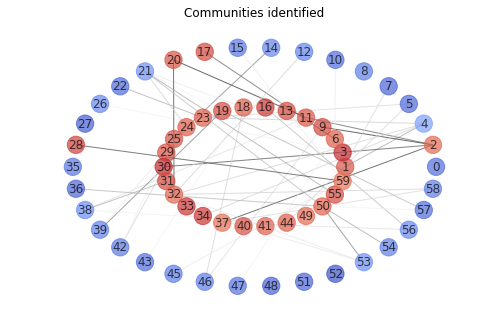

In [150]:
sim = CommunityAlgorithm(network_size=60, network_type = "erdos")
sim.initialize()

sim.run(2, 1000, graph_type = "spring", visualize=False)

scores = sim.community_finding(visualize=True)

In [132]:
def plot_SC_score(clustering_trials, num_networks=5, runs_for_netw=3000):
    """
    Generates 3 plots, for each of the main network types, plotting
    self-consistency as a measure of clustering trials (min 3),
    averaged across several networks, each run runs_for_netw times.
    Network size is set to 60 by default.
    
    Inputs:
        clustering_trials (list) a list of the number of trials that
        should be done for each network, for each initial setup.
        This will be plotted on the x-axis.
        
        nume_networks (int) accross how many different initial layouts
        the algorithm should be tested. Default: 5
        
        runs_for_network (int) steps that each network should be 
        updated for before the clustering is performed. Default: 3000
    """
    
    graph_types = ['barabasi', 'erdos', 'watts']
    
    for graph in graph_types:
        
        plt.clf()
        scores_total = np.zeros((num_networks, 60, len(clustering_trials)))
        
        for network in range(num_networks):
            
            sim = CommunityAlgorithm(network_size=60, network_type = graph)
            sim.initialize()
            
            sim.run(3, runs_for_netw//3, graph_type = "spring", visualize=False)
            
            trial_scores = np.zeros((60, len(clustering_trials)))
            for t, trial in enumerate(clustering_trials):
                
                scores = sim.community_finding(clustering_trials=trial, 
                                               visualize=False)
                trial_scores[:, t] = scores
                
            scores_total[network, :, :] = trial_scores
        
        mean_scores = np.mean(scores_total, axis=(0,1))
        
        #mean line
        plt.plot(clustering_trials, mean_scores)

        #getting descriptive stats to plot confidence intervals
        avg_trials = np.sort(np.mean(scores_total, axis=0), axis=0)
        _lower_bound = [avg_trials[2, i] for i in range(len(clustering_trials))]
        _upper_bound = [avg_trials[56, i] for i in range(len(clustering_trials))]
        
        #plotting CIs
        plt.plot(clustering_trials, _upper_bound, color='k', alpha=0.3)
        plt.plot(clustering_trials, _lower_bound, color='k', alpha=0.3)
        
        plt.xlim((5,20))
        plt.xlabel("Clustering trials")
        plt.ylabel("Self-consistency score")
        
        plt.title(str(graph))
        plt.show()

## Results

Below are three figures showing the algorithm's self-consistency score with 90% confidence intervals across 30 distinct networks for the differing number of clustering trials run on each network.

They show that there is no significant convergence if the algorithm is run for more trials and the self-consistency scores are high for both Barabasi-Albert graphs and Erdos-Renyi graphs, where confidence intervals are close to the mean line. This suggests that the algorithm performs consistently well on these graph types.

On the Watts-Strogatz model, the algorithm performs slightly less ideally, with self-consistency scores centering around the 78% mark and the variance across number of clustering trials being lower (note that because the mode determines the final label, this score should not be significantly lower than 50%, unless the network returns more clusters than trials are performed). Other than the number of trials until the networks diverge, I have found no clear explanation for the differences in these scores.

A sample community is shown for each graph type below.

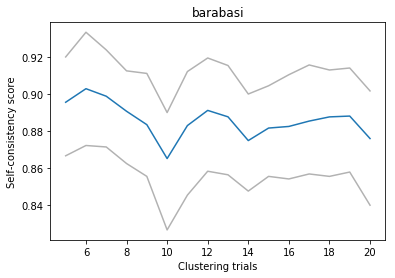

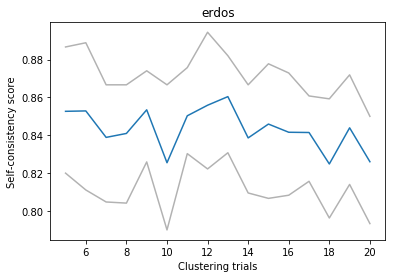

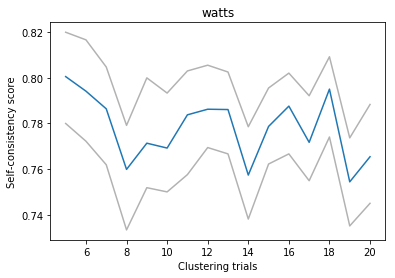

In [189]:
plot_SC_score(clustering_trials=range(5,21), num_networks=30, runs_for_netw=6000)

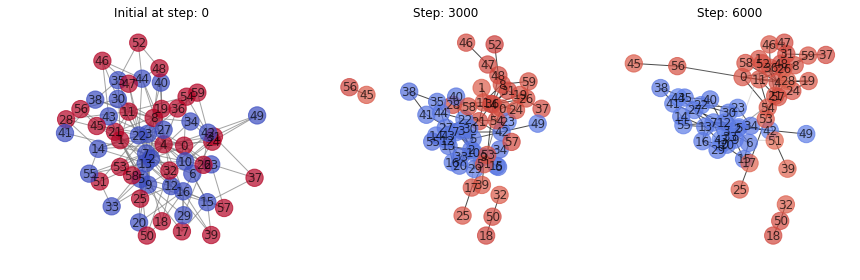

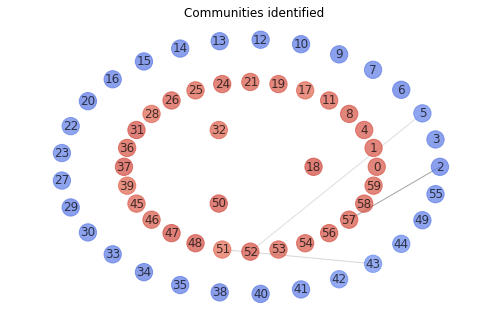

In [187]:
sim = CommunityAlgorithm(network_size=60, network_type = "barabasi")
sim.initialize()

sim.run(3, 3000, graph_type = "spring", visualize=True)

_ = sim.community_finding(visualize=True)

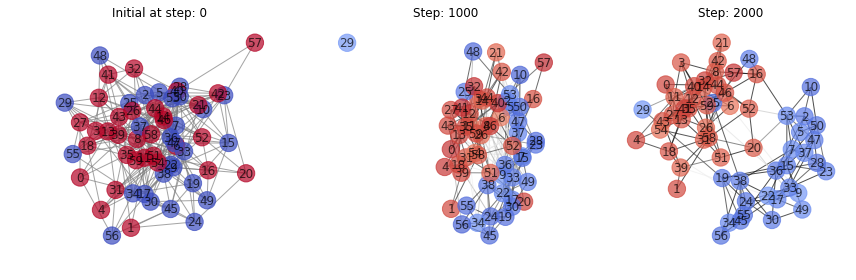

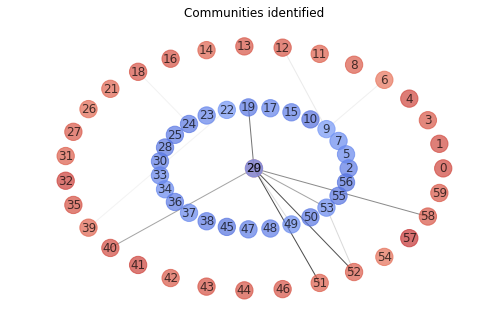

In [157]:
sim = CommunityAlgorithm(network_size=60, network_type = "erdos")
sim.initialize()

sim.run(3, 1000, graph_type = "spring", visualize=True)

_ = sim.community_finding(visualize=True)

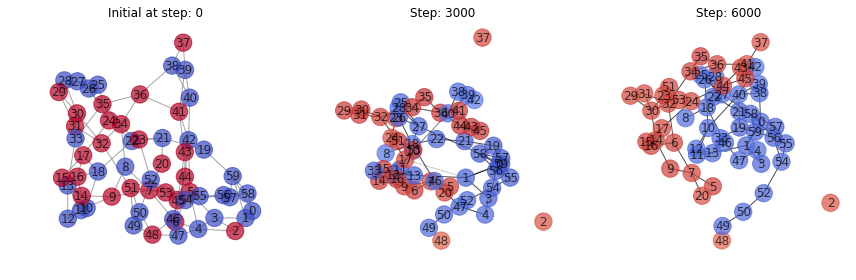

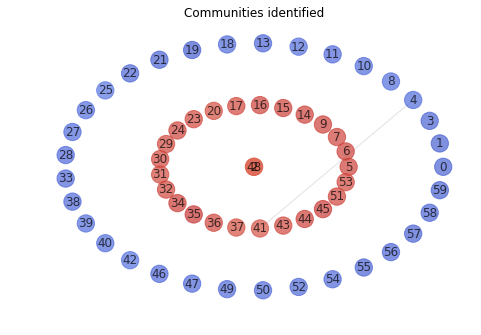

In [188]:
sim = CommunityAlgorithm(network_size=60, network_type = "watts")
sim.initialize()

sim.run(3, 3000, graph_type = "spring", visualize=True)

_ = sim.community_finding(visualize=True)

### Takeaways

The metric I have chosen for the algorithm confirms the performance is internally consistent (and appears dependent on graph type, which in turn is dependent on the number of runs, since some graphs cluster faster than others). The results presented, however, do not show whether the algorithm would generalize well to unusual or unseen graph structures since it was designed with a specific kind of small-world graph structure in mind. It would also have to be modified to account for networks where connection weights do not carry the same significance as they do in the network simulation. Additionally, it would be interesting to test the algorithm on the network extension that inspired it, which naturally leads to more clusters forming. Performance on multi-cluster graphs might differ significantly and the more communities exist, the more clustering-trials parameter might impact performance.

For the specific goal, I had in mind, however, the algorithm performs well. It visualizes the clusters in the desired manner, showing only across-cluster connections. As an example of the kind of information I wanted to receive, the Erdos-Renyi example above serves as an example. It shows that node number 20 and 29 are the main two connectors between the blue and red opinion group, information that is not apparent from the default spring-layout right above, even though they contain the same network.